In [1]:
!pip install opencv-python


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


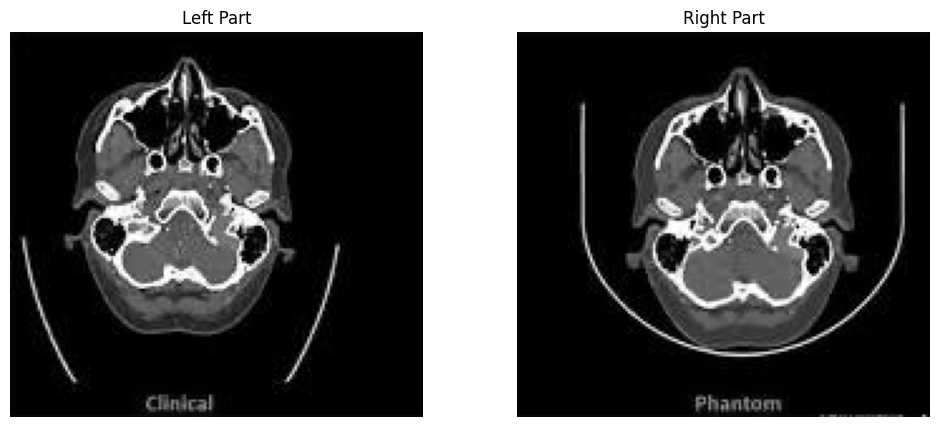

In [3]:

image = cv2.imread('cv-foto.jpg', cv2.IMREAD_GRAYSCALE)
height, width = image.shape
part1 = image[:, 0:width // 2]
part2 = image[:, width // 2:width]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(part1, cmap='gray')
plt.title('Left Part')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(part2, cmap='gray')
plt.title('Right Part')
plt.axis('off')
plt.show()


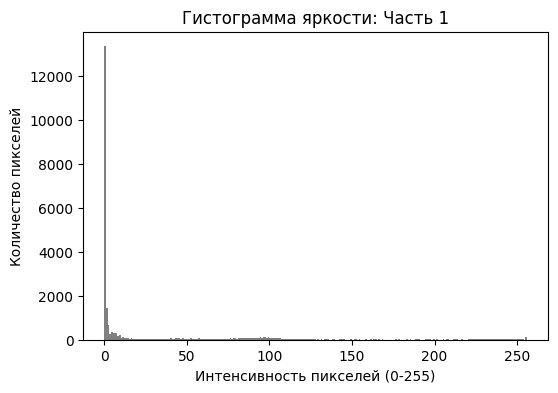

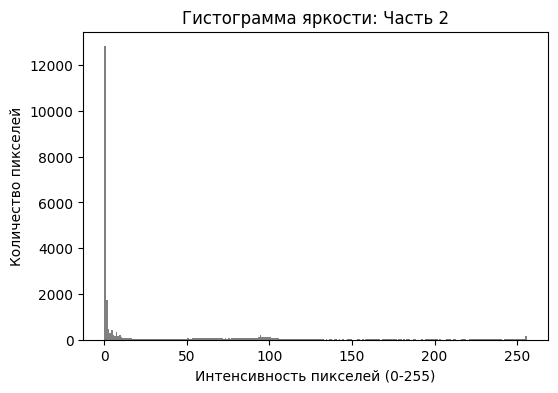

In [4]:
parts = (part1, part2)
for i, part in enumerate(parts):
    plt.figure(figsize=(6, 4))
    plt.title(f"Гистограмма яркости: Часть {i+1}")
    plt.xlabel("Интенсивность пикселей (0-255)")
    plt.ylabel("Количество пикселей")
    plt.hist(part.ravel(), bins=256, range=[0, 256], color='gray')
    plt.show()

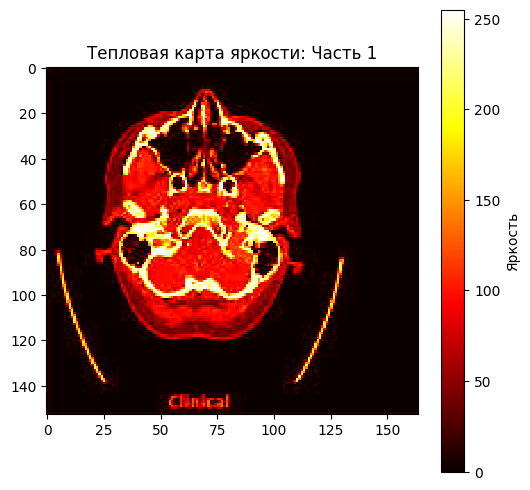

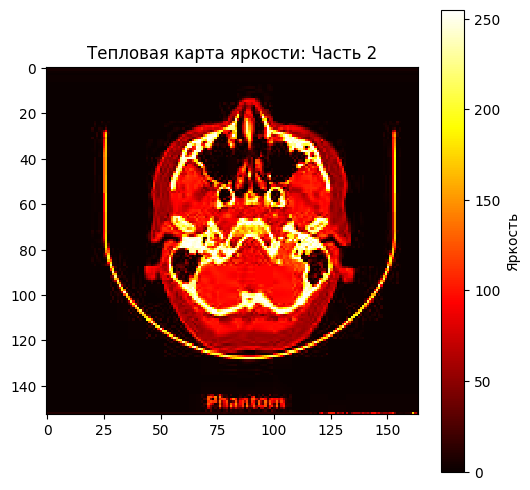

In [5]:
for i, part in enumerate(parts):
    plt.figure(figsize=(6, 6))
    plt.title(f"Тепловая карта яркости: Часть {i+1}")
    plt.imshow(part, cmap='hot', interpolation='nearest')
    plt.colorbar(label="Яркость")
    plt.show()

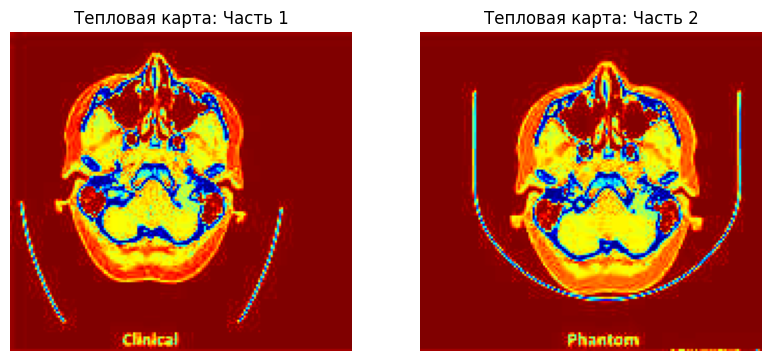

In [6]:
plt.figure(figsize=(15, 5))

for i, part in enumerate(parts):
    heatmap = cv2.applyColorMap(part, cv2.COLORMAP_JET)
    plt.subplot(1, 3, i+1)
    plt.imshow(heatmap)
    plt.title(f'Тепловая карта: Часть {i+1}')
    plt.axis('off')
    cv2.imwrite(f"heatmap_part_{i+1}.png", heatmap)

plt.show()

In [7]:
def moments_calc(img, powers=[1, 2, 3, 4]):
    strt_moments = []
    cntr_moments = [0 for _ in range(len(powers))]
    height, width = img.shape
    multiplicity = height * width

    for power in powers:
        moment = np.sum(np.power(img, power)) / multiplicity
        strt_moments.append(moment)

    mean_value = strt_moments[0]
    cntr_moments[1] = strt_moments[1] - mean_value ** 2 
    cntr_moments[2] = strt_moments[2] - 3 * mean_value * strt_moments[1] + 2 * mean_value ** 2 
    cntr_moments[3] = strt_moments[3] - 4 * mean_value * strt_moments[2] + 6 * mean_value ** 2 * strt_moments[1] - 3 * mean_value ** 4

    strt_moments = [round(float(x), 3) for x in strt_moments]
    cntr_moments = [round(float(x), 3) for x in cntr_moments]

    return strt_moments, cntr_moments


In [8]:
def entropy_calc(img):
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    probabilities = hist / np.sum(hist)
    probabilities = probabilities[probabilities > 0]
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return round(float(entropy), 3)


In [9]:
def calculate_entropy_with_histogram(img):
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    total_pixels = np.sum(hist)
    non_zero_hist = hist[hist > 0]
    term1 = np.log2(total_pixels)
    term2 = np.sum(non_zero_hist * np.log2(non_zero_hist)) / total_pixels
    entropy = term1 - term2
    return round(float(entropy), 3)

In [10]:
def calculate_redundancy(img):
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    total_pixels = np.sum(hist)
    non_zero_hist = hist[hist > 0]
    term1 = np.log2(total_pixels)
    term2 = np.sum(non_zero_hist * np.log2(non_zero_hist)) / total_pixels
    I = term1 - term2
    h_max = 255
    h_min = 0 
    I_0 = np.log2(h_max - h_min + 1)
    D = 1 - (I / I_0)
    return D


In [24]:
for i, part in enumerate(parts):
    part_float = part.astype(np.float32)

    start_moms, center_moms = moments_calc(part_float)
    entropy1 = entropy_calc(part_float)
    entropy2 = calculate_entropy_with_histogram(part_float)
    redundancy = calculate_redundancy(part_float)
    print(f'Для части {i+1}: ')
    print(f'Начальные моменты: {start_moms}')
    print(f'Центральные моменты: {center_moms}')
    print(f'Энтропия (как средняя собственная информация): {entropy1:.4f}')
    print(f'Энтропия (через гистограмму): {entropy2:.4f}')
    print(f'Избыточность: {redundancy:.4f}')


Для части 1: 
Начальные моменты: [30.388, 4217.085, 748344.438, 152089952.0]
Центральные моменты: [0.0, 3293.629, 0.0, 0.0]
Энтропия (как средняя собственная информация): 4.1740
Энтропия (через гистограмму): 4.1740
Избыточность: 0.4783
Для части 2: 
Начальные моменты: [33.376, 4607.35, 806488.25, 161978752.0]
Центральные моменты: [0.0, 3493.397, 0.0, 0.0]
Энтропия (как средняя собственная информация): 4.3130
Энтропия (через гистограмму): 4.3130
Избыточность: 0.4608


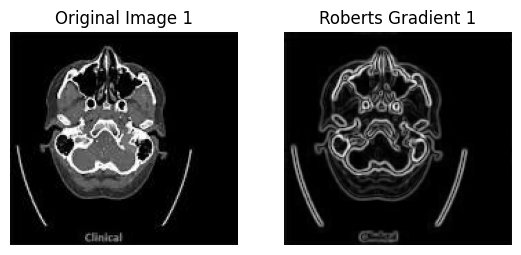

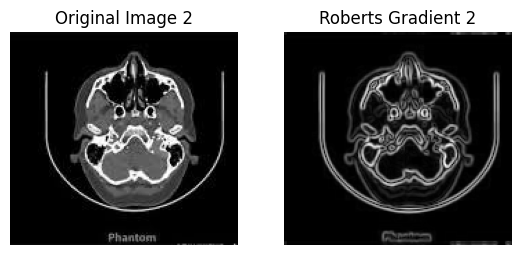

In [25]:
for i, part in enumerate(parts):
    blurred_part = cv2.GaussianBlur(part, (3, 3), 1)
    extended_image = cv2.copyMakeBorder(blurred_part, 1, 1, 1, 1, cv2.BORDER_WRAP) 
    kernel_x = np.array([[1, 0], [0, -1]])
    kernel_y = np.array([[0, 1], [-1, 0]])
    grad_x = cv2.filter2D(extended_image, cv2.CV_64F, kernel_x)
    grad_y = cv2.filter2D(extended_image, cv2.CV_64F, kernel_y)
    roberts_grad = cv2.magnitude(grad_x, grad_y)
    roberts_grad = np.uint8(np.clip(roberts_grad, 0, 255)) 

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(part, cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(roberts_grad, cmap='gray')
    plt.title(f'Roberts Gradient {i+1}')
    plt.axis('off')
    plt.show()


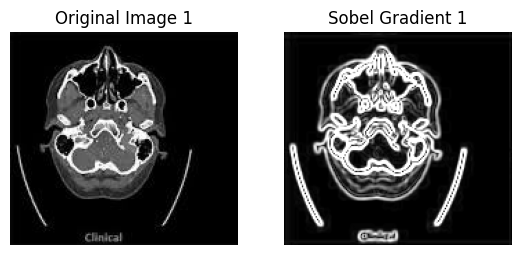

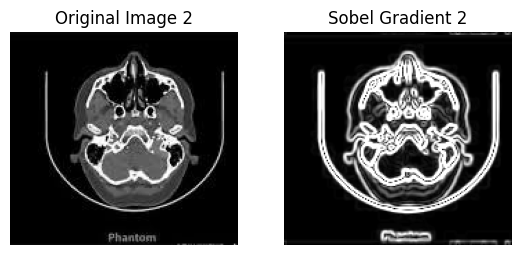

In [13]:
new_parts = []
for i, part in enumerate(parts):
    blurred_part = cv2.GaussianBlur(part, (3, 3), 1)
    extended_image = cv2.copyMakeBorder(blurred_part, 1, 1, 1, 1, cv2.BORDER_WRAP)  
    grad_x = cv2.Sobel(extended_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(extended_image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_grad = cv2.magnitude(grad_x, grad_y)
    sobel_grad = np.uint8(np.clip(sobel_grad, 0, 255))
    new_parts.append(sobel_grad)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(part, cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(sobel_grad, cmap='gray')
    plt.title(f'Sobel Gradient {i+1}')
    plt.axis('off')
    plt.show()


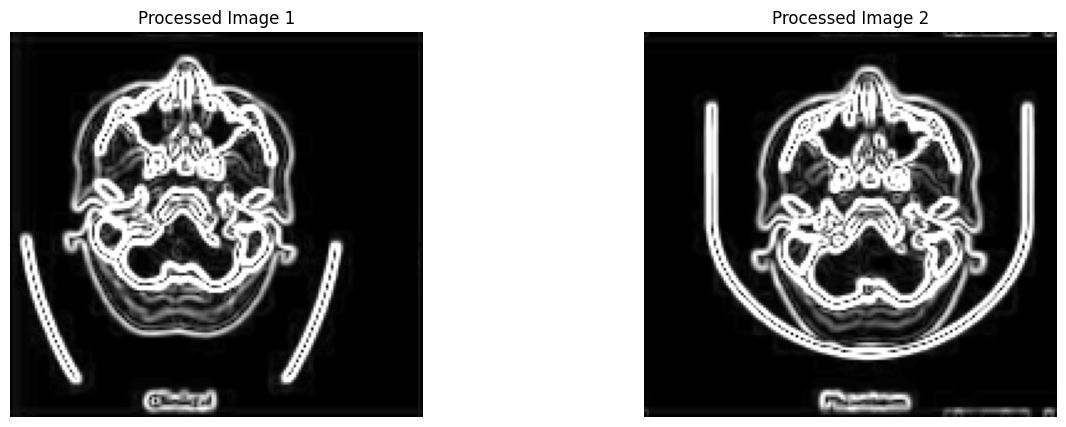

In [14]:
plt.figure(figsize=(15, 5))

for i, part in enumerate(new_parts):
    plt.subplot(1, len(new_parts), i + 1)
    plt.imshow(part, cmap='gray')
    plt.title(f'Processed Image {i+1}')
    plt.axis('off')

plt.show()


In [26]:
for i, part in enumerate(new_parts):
    part_float = part.astype(np.float32)
    start_moms, center_moms = moments_calc(part_float)
    entropy1 = entropy_calc(part_float)
    entropy2 = calculate_entropy_with_histogram(part_float)
    redundancy = calculate_redundancy(part_float)
    print(f'Для части {i+1}: ')
    print(f'Начальные моменты: {start_moms}')
    print(f'Центральные моменты: {center_moms}')
    print(f'Энтропия (как средняя собственная информация): {entropy1:.4f}')
    print(f'Энтропия (через гистограмму): {entropy2:.4f}')
    print(f'Избыточность: {redundancy:.4f}')


Для части 1: 
Начальные моменты: [50.144, 9437.63, 2091111.375, 490478752.0]
Центральные моменты: [0.0, 6923.202, 0.0, 0.0]
Энтропия (как средняя собственная информация): 4.7060
Энтропия (через гистограмму): 4.7060
Избыточность: 0.4118
Для части 2: 
Начальные моменты: [56.669, 11008.701, 2465234.0, 581035392.0]
Центральные моменты: [0.0, 7797.341, 0.0, 0.0]
Энтропия (как средняя собственная информация): 4.7470
Энтропия (через гистограмму): 4.7470
Избыточность: 0.4067


In [16]:
def count_pixels_above_threshold(block, threshold):
    mask = block > threshold
    return np.sum(mask)

In [17]:
def truncated_block_coding(image, m=8, n=8):
    h, w = image.shape
    compressed_image = np.zeros_like(image)

    for i in range(0, h, m):
        for j in range(0, w, n):
            block = image[i:i + m, j:j + n]
            p = block.size  
            c = np.sum(block) / p  
            e = np.sum(block ** 2) / p  
            std = np.sqrt(e - c ** 2)
            q = count_pixels_above_threshold(block, c)
            if p - q == 0:  
                a = c
                b = c
            else:
                a = c - std * np.sqrt(q / (p - q))
                b = c + std * np.sqrt(q / (p - q))
            for x in range(block.shape[0]): 
                for y in range(block.shape[1]):
                    pix = block[x, y]
                    if pix < c:
                        compressed_image[i + x, j + y] = a
                    else:
                        compressed_image[i + x, j + y] = b

    return compressed_image

In [18]:
def moments_calc(img, powers=[1, 2, 3, 4]):
    strt_moments = []
    cntr_moments = [0 for _ in range(len(powers))]
    height, width = img.shape
    multiplicity = height * width

    for power in powers:
        moment = np.sum(np.power(img, power)) / multiplicity
        strt_moments.append(moment)

    mean_value = strt_moments[0] 
    cntr_moments[1] = strt_moments[1] - mean_value ** 2 
 
    strt_moments = [round(float(x), 3) for x in strt_moments]
    cntr_moments = [round(float(x), 3) for x in cntr_moments]

    return strt_moments, cntr_moments


In [19]:
def show_images(original, compressed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Оригинал')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(compressed, cmap='gray')
    plt.title('Сжато (Усечённое кодирование)')
    plt.axis('off')
    plt.show()

Часть 1:
Стартовые моменты: [48.165, 9440.206]
Центральные моменты: [0.0, 7120.315]
Среднеквадратичное отклонение: 84.382



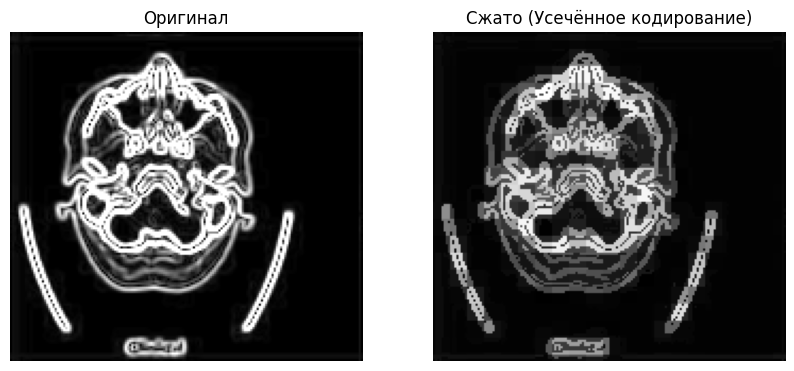

Часть 2:
Стартовые моменты: [55.438, 11466.626]
Центральные моменты: [0.0, 8393.25]
Среднеквадратичное отклонение: 91.615



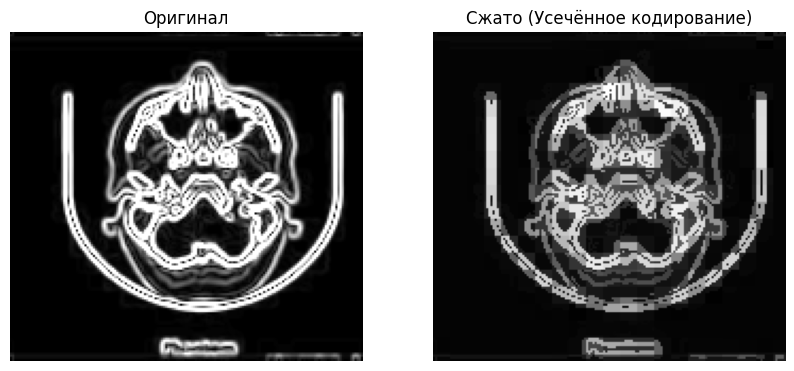

In [20]:
comp_parts = []
for i, part in enumerate(new_parts):
    part_float = part.astype(np.float32)
    compressed_part = truncated_block_coding(part_float, m=8, n=8)
    comp_parts.append(compressed_part)
    strt_moments, cntr_moments = moments_calc(compressed_part, powers=[1, 2])
    if cntr_moments[1] > 0:
        std_deviation = round(np.sqrt(cntr_moments[1]), 3)
    else:
        std_deviation = 0.0  
        
    print(f"Часть {i + 1}:")
    print(f"Стартовые моменты: {strt_moments}")
    print(f"Центральные моменты: {cntr_moments}")
    print(f"Среднеквадратичное отклонение: {std_deviation}")
    print()
    show_images(part_float, compressed_part)

In [21]:
def affine_transform(image, transformation_type, *params):
    h, w = image.shape
    if transformation_type == 'shift':
        tx, ty = params
        M = np.float32([[1, 0, tx], [0, 1, ty]]) 
    elif transformation_type == 'rotate_scale':
        angle, scale, tx, ty = params
        M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, scale) 
    elif transformation_type == 'scale_rotate':
        scale, angle, tx, ty = params
        M = np.float32([[scale * np.cos(angle), scale * np.sin(angle), tx],
                        [-scale * np.sin(angle), scale * np.cos(angle), ty]]) 
    else:
        raise ValueError(f"Unknown transformation type: {transformation_type}")

    transformed_image = cv2.warpAffine(image, M, (w, h))
    return transformed_image

In [22]:
def show_images(original, transformed, title="Transformed Image"):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(transformed, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

Часть 1:


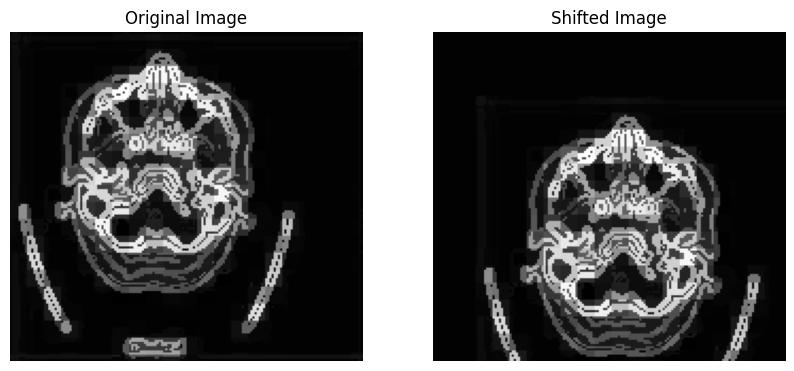

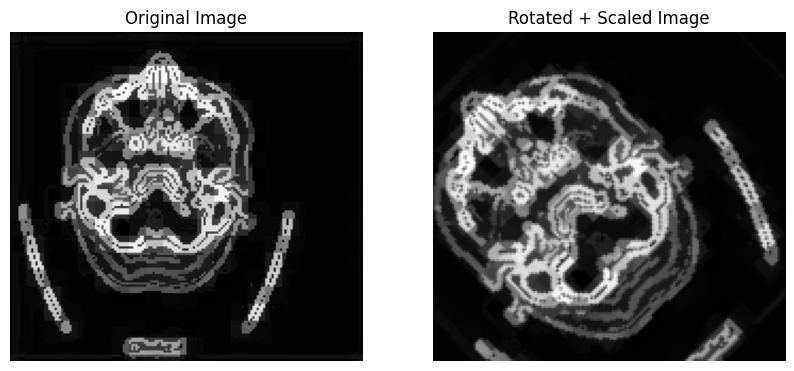

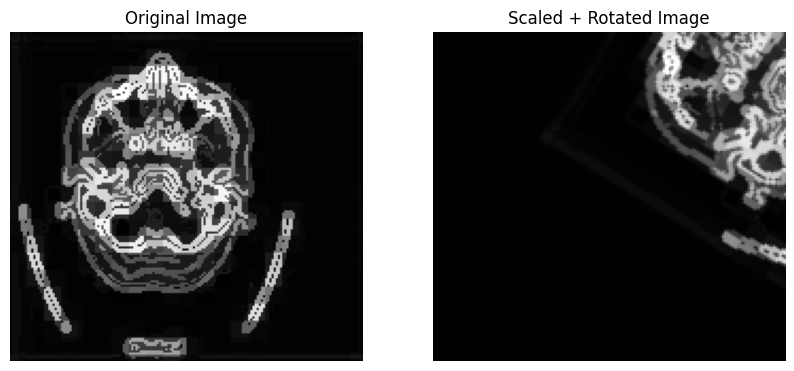

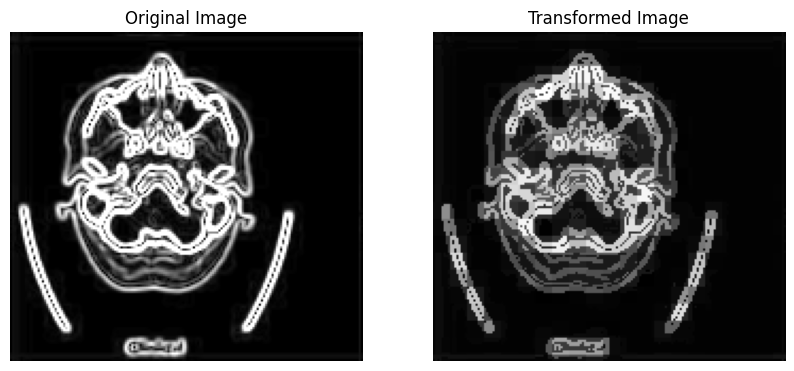

Часть 2:


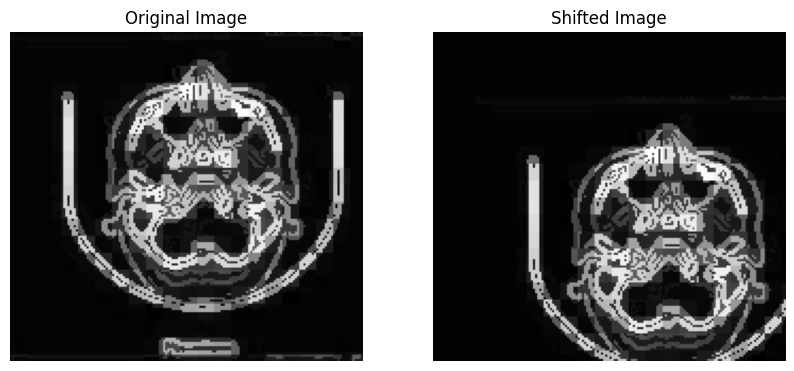

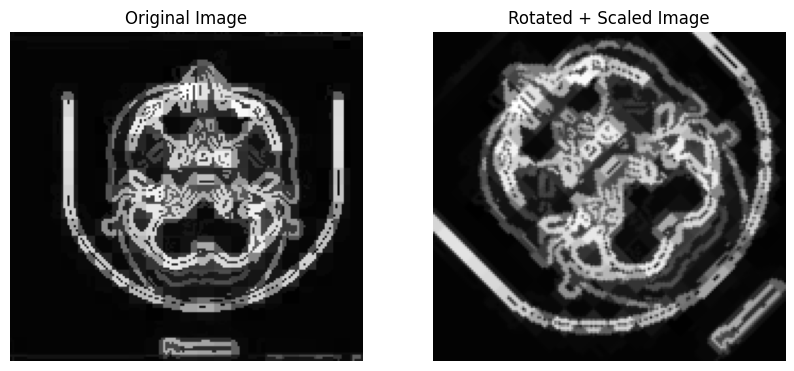

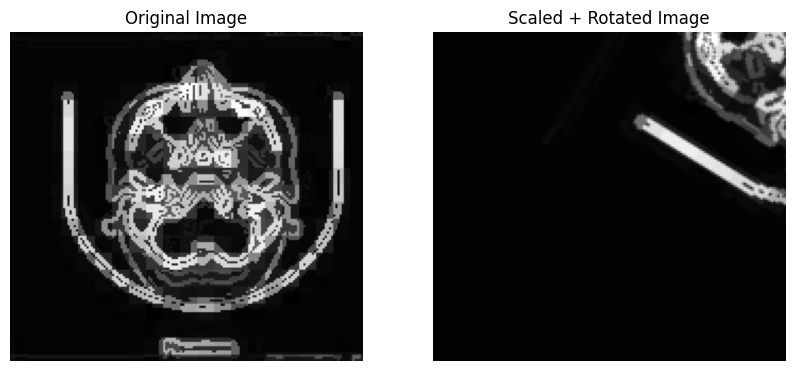

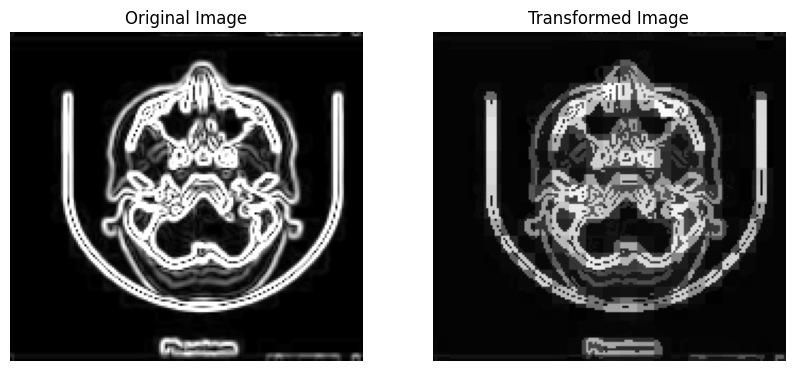

In [23]:
comp_parts = []
for i, part in enumerate(new_parts):
    print(f"Часть {i + 1}:")
    part_float = part.astype(np.float32)
    compressed_part = truncated_block_coding(part_float, m=8, n=8)
    comp_parts.append(compressed_part)
    shifted_part = affine_transform(compressed_part, 'shift', 20, 30)
    show_images(compressed_part, shifted_part, title="Shifted Image")
    rotated_scaled_part = affine_transform(compressed_part, 'rotate_scale', 45, 1.2, 50, 50)
    show_images(compressed_part, rotated_scaled_part, title="Rotated + Scaled Image")
    scaled_rotated_part = affine_transform(compressed_part, 'scale_rotate', 1.2, 45, 50, 50)
    show_images(compressed_part, scaled_rotated_part, title="Scaled + Rotated Image")
    strt_moments, cntr_moments = moments_calc(compressed_part, powers=[1, 2])
    
    if cntr_moments[1] > 0:
        std_deviation = round(np.sqrt(cntr_moments[1]), 3)
    else:
        std_deviation = 0.0  
    show_images(part_float, compressed_part)